In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Problem 1: Predicting House Prices

In [3]:
# load the data
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/kc_house_data.csv'
sales = pd.read_csv(url, index_col='id')
sales.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


This dataset contains house sale prices for King County, which includes Seattle. 
It includes homes sold between May 2014 and May 2015.

There are 21 columns:

| Column | Description |
| :- | -: |
| id | Unique ID for each home sold |
| date | Date of the home sale |
| price | Price of each home sold |
| bedrooms | Number of bedrooms |
| bathrooms | Number of bathrooms, where .5 accounts for a room with a toilet but no shower |
| sqft_living | Square footage of the apartments interior living space |
| sqft_lot | Square footage of the land space |
| floors | Number of floors |
| waterfront | A dummy variable for whether the apartment was overlooking the waterfront or not |
| view | An index from 0 to 4 of how good the view of the property was |
| condition | An index from 1 to 5 on the condition of the apartment |
| grade | An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design |
| sqft_above | The square footage of the interior housing space hat is above ground level |
| sqft_basement | The square footage of the interior housing space that is below ground level |
| yr_built | The year the house was initially built |
| yr_renovated | The year of the house's last renovation |
| zipcode | What zipcode area the house is in |
| lat | Latitude |
| long | Longitude |
| sqft_living15 | The square footage of interior housing living space for the nearest 15 neighbors |
| sqft_lot15 | The square footage of the land lots of the nearest 15 neighbors |

In [4]:
sales.dtypes

date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [5]:
sales_numeric_cols = sales.select_dtypes(include=[np.number]).columns
# drop lat and long - should be irrelevant
sales_numeric_cols = sales_numeric_cols.drop(['lat','long', 'price'])
sales = sales.drop(['lat','long'],axis=1)

Your **goal** is to **train** a regression pipeline that predicts house prices, **tune** the pipeline hyperparameters, and **test** its performance.

In [6]:
# import model
from sklearn.linear_model import LinearRegression
# pipeline
from sklearn.pipeline import Pipeline
# preprocessing
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
# model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# metrics
from sklearn.metrics import accuracy_score, mean_squared_error

In [7]:
# split data into training and testing sets
X = sales.drop('price', axis=1)
y = sales['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# create pipeline
numeric_features = sales_numeric_cols
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])

categorical_features = ['waterfront','view','condition','grade', 'zipcode']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

pipe_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('poly', PolynomialFeatures(degree=2)),
                        ('reg', LinearRegression())])

# fit the model
pipe_model.fit(X_train, y_train)

# predict
y_pred = pipe_model.predict(X_test)

# evaluate the model
print('RMSE', mean_squared_error(y_test, y_pred, squared=False))

# accuracy
print('Accuracy:', pipe_model.score(X_test, y_test))

RMSE 169606.1068498346
Accuracy: 0.8076964480735331


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/kc_house_data.csv'
data = pd.read_csv(url)

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y%m%dT%H%M%S')

# Check the entries with duplicate IDs to understand the nature of the duplicates
duplicates = data[data['id'].duplicated(keep=False)].sort_values(by='id')

# Drop older duplicates and keep only the most recent sale for each ID
most_recent_sales = duplicates[duplicates.groupby('id')['date'].transform('max') == duplicates['date']]
data_cleaned = data.drop_duplicates(subset='id', keep=False)
data_cleaned = pd.concat([data_cleaned, most_recent_sales], ignore_index=True)

# Define the features (X) and the target (y)
X = data_cleaned.drop(['price', 'id', 'date'], axis=1)  # drop 'id' and 'date' as they are not predictive
y = data_cleaned['price']

# Initialize a RobustScaler
scaler = RobustScaler()

# Scale the features (X)
X_scaled = scaler.fit_transform(X)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Predict on the training set and the test set
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Calculate the performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200],  # The number of trees in the forest
    'max_depth': [10, 20, None],  # The maximum depth of the trees
    'min_samples_split': [2, 5],  # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # The minimum number of samples required to be at a leaf node
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search on the training data
# grid_search.fit(X_train, y_train)  # Commented out due to time constraints


Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\bovam\miniconda3\envs\sportsenv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\bovam\miniconda3\envs\sportsenv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\bovam\miniconda3\envs\sportsenv\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\bovam\miniconda3\envs\sportsenv\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_paramete

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Train MSE: 2637137977.107
Train R^2: 0.980
Test MSE: 17695926524.135
Test R^2: 0.871


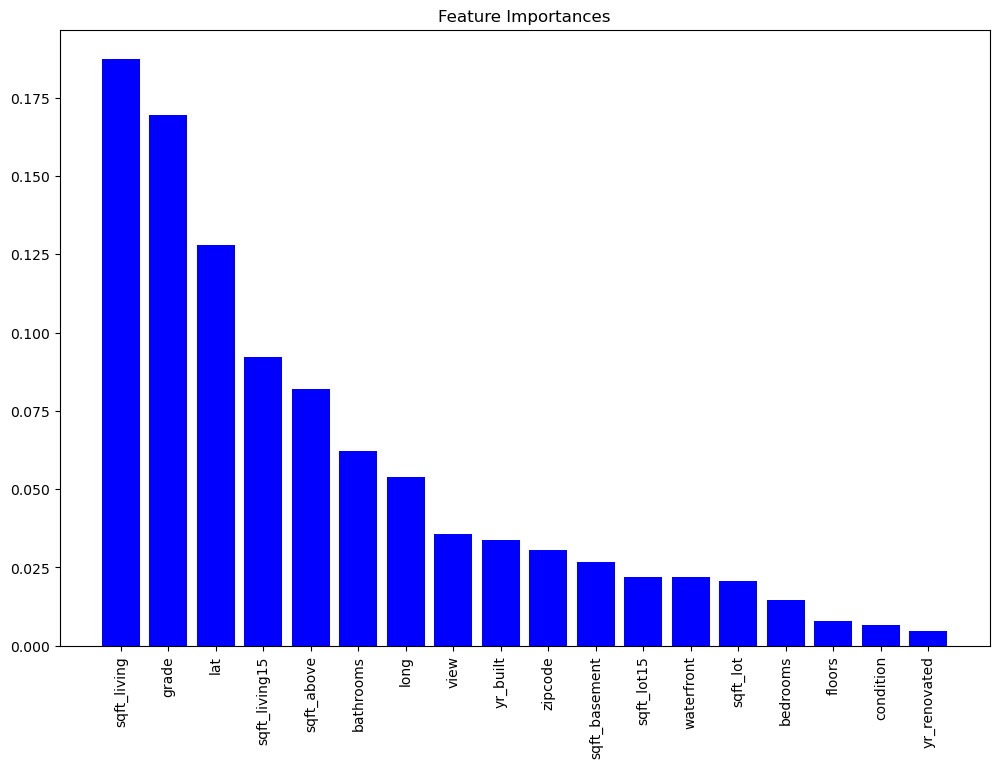

In [ ]:
grid_search.fit(X_train, y_train)

# Get the best parameters
print(grid_search.best_params_)

# Get the best estimator
best_rf_regressor = grid_search.best_estimator_

# Predict on the training set and the test set
y_train_pred = best_rf_regressor.predict(X_train)
y_test_pred = best_rf_regressor.predict(X_test)

# Calculate the performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the performance metrics
print('Train MSE: {:.3f}'.format(train_mse))
print('Train R^2: {:.3f}'.format(train_r2))
print('Test MSE: {:.3f}'.format(test_mse))
print('Test R^2: {:.3f}'.format(test_r2))

# Plot the feature importances
importances = best_rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='b', align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.show()

**Plot** the observed prices against the predicted prices.

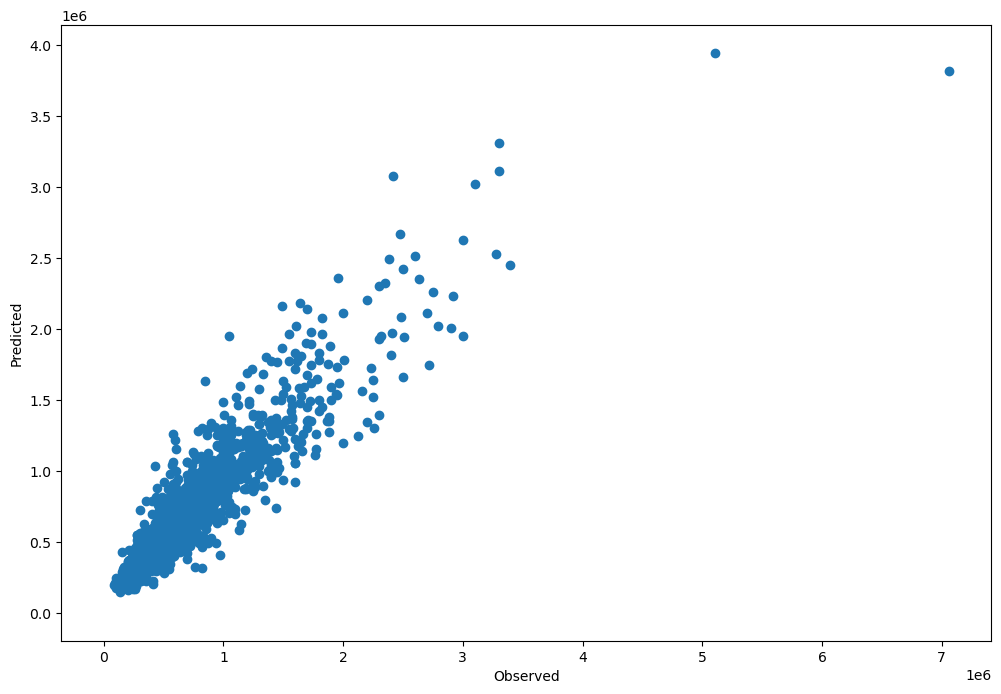

In [ ]:
# plot observed vs predicted
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_test_pred)
plt.plot([0, 1], [0, 1], '--k')
plt.axis('tight')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()